In [1]:
import numpy as np
import matplotlib.pyplot as plt

import imripy
from imripy import constants as c, kepler, merger_system as ms

from scipy.interpolate import interp1d

### Define dark matter halo properties

The code works in geometrized units with $c=G=1$, which means that energy, length, time, and mass all have the same units (see for example $E=mc^2 = m$, and $1 = c = \text{length}/\text{time}$)

We can choose which unit we want to describe them with, and usually parsecs is chosen ($1$pc$\approx 3.26$ light years$\approx 3.09\cdot 10^{16}$m). To this end, the imripy.constants file has a few constants for the transformation.

In [2]:
# Dark matter spike with the values from the Eda paper
r_spike = 0.54  # in parsecs

alpha = 7./3.

rho_spike = 226. * c.solar_mass_to_pc  # This takes the value of 226 M_sun/pc^3 and converts it to 1/pc^2

spike = imripy.halo.Spike(rho_spike, r_spike, alpha)

In [3]:
# NFW for comparison
r_s = 23.1
rho_s = 3.8e-22 *c.g_cm3_to_invpc2
nfw = imripy.halo.NFW(rho_s, r_s)

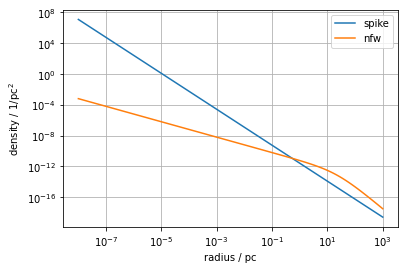

In [4]:
# Plot density
r_grid = np.geomspace(1e-8, 1e3, 100)  # creates a grid in pc
plt.loglog(r_grid, spike.density(r_grid), label='spike')
plt.loglog(r_grid, nfw.density(r_grid), label='nfw')
plt.grid(); plt.xlabel("radius / pc"); plt.ylabel("density / 1/pc$^2$"); plt.legend()

### Define the IMRI system

In [5]:
m1 =  1e4 * c.solar_mass_to_pc   # The central mass m1 with a mass of 1e4 solar masses, converted to pc

m2 = 1. * c.solar_mass_to_pc   # The secondary mass

D_luminosity = 5e8              # The distance to the system from earth as 500 Mpc

hs = ms.HostSystem(m1, halo=spike, D_l=D_luminosity)   # Create the HostSystem object describing the central system

### Define initial conditions for a circular inspiral

In [6]:
R0 = 100. * hs.r_isco    # Start the inspiral from an initial separataion of 100 * r_isco, the radius of the 
                            # innermost stable ciricular orbit

ko_initial = kepler.KeplerOrbit(hs, m2, R0)

### Solve the differential equations

In [7]:
ev = imripy.inspiral.Classic.Evolve(hs, ko_initial)

Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-10
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.0681s real time


In [8]:
#  The evolution result has the following parameters
attr = []
for d in dir(ev):
    if not "__" in d and d not in dir(kepler.KeplerOrbit):
        attr.append(d)
# with the time t, radius R (in the circular case), semimajor axis a, eccentricity e, secondary mass m2
# integration message msg, the EvolutionOptions used options, and the SystemProp object used sp
print(attr)

['R', 'a', 'a_int', 'e', 'e_int', 'get_kepler_orbit', 'hs', 'inclination_angle', 'inclination_angle_int', 'interpolate', 'load', 'longitude_an', 'longitude_an_int', 'm2', 'm2_int', 'msg', 'options', 'periapse_angle', 'periapse_angle_int', 'prograde', 'save', 't']


Text(0, 0.5, 'radius / $r_{isco}$')

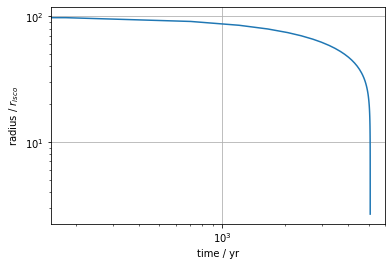

In [9]:
# Plot the result
plt.loglog(ev.t/c.year_to_pc,  ev.R/hs.r_isco)
plt.grid(); plt.xlabel("time / yr"); plt.ylabel("radius / $r_{isco}$")

Text(0, 0.5, 'radius / $r_{isco}$')

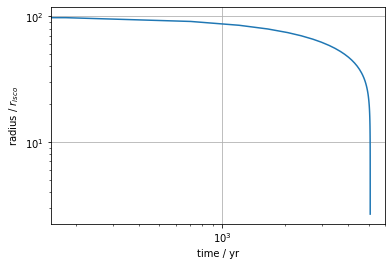

In [10]:
# Alternatively use the plot_utils (which becomes more useful when several things are plotted, such as eccentricity)
imripy.plot_utils.plotEvolution(hs, ev, ax_a=plt.gca())
plt.grid(); plt.xlabel("time / yr"); plt.ylabel("radius / $r_{isco}$")

In [11]:
# You can optionally save the result and load it again later
# ev.save("inspiral.npz")

### Calculate the gravitational wave signal

Text(0.5, 0, 'time to merger / s')

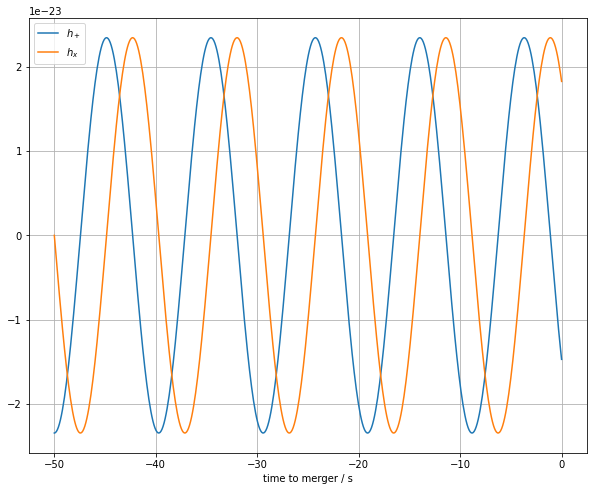

In [12]:
# First, the gravitational wave signal right before inspiral
tom = ev.t[-2]    # time of merger
t_grid = np.linspace(tom-50.*c.s_to_pc, tom, 500)   # Look at the last 50s of inspiral
h_plus, h_cross = imripy.waveform.h(hs, ev, t_grid)

plt.figure(figsize=(10,8))
plt.plot((t_grid - tom)/c.s_to_pc, h_plus, label="$h_+$")
plt.plot((t_grid - tom)/c.s_to_pc, h_cross, label="$h_x$")
plt.grid(); plt.legend(); plt.xlabel("time to merger / s")

Text(0, 0.5, 'characteristic strain')

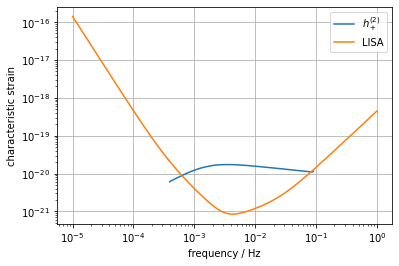

In [13]:
# The characteristic strain of the signal compared to the LISA sensitivity
f_gw, h_2_plus, h_2_cross, _ = imripy.waveform.h_2(hs, ev)
plt.loglog(f_gw/c.hz_to_invpc, 2.* f_gw*h_2_plus, label="$h_+^{(2)}$")

Lisa = imripy.detector.Lisa()
f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
plt.loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA')
plt.grid(); plt.legend(); plt.xlabel("frequency / Hz"); plt.ylabel("characteristic strain")

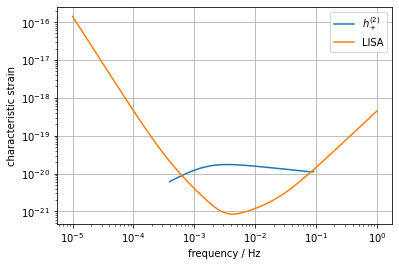

In [14]:
# Alternatively use the plot_utils
imripy.plot_utils.plotGWcharacteristicStrain(hs, ev, plt.gca(), harmonics=[2], label="$h_+^{(2)}$")

f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
plt.loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA')
plt.legend(); plt.xlabel("frequency / Hz"); plt.ylabel("characteristic strain")
plt.grid()

### Calculate dephasing

In [15]:
# To calculate the dephasing, we need the vacuum case for comparison
noDF = imripy.inspiral.Classic.EvolutionOptions(dynamicalFrictionLoss=False)
ev_0 = imripy.inspiral.Classic.Evolve(hs, ko_initial, opt=noDF)

Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-10
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.0404s real time


Text(0, 0.5, '$\\Delta N$')

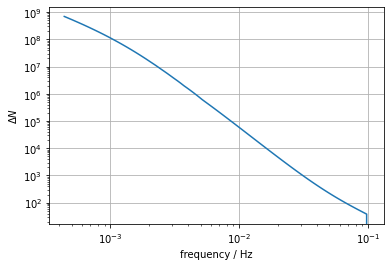

In [16]:
# Now calculate N_cycles for both cases and compare
f_gw_0, N_0 = imripy.waveform.N_cycles_n(2, hs, ev_0)
N_0_interp = interp1d(f_gw_0, N_0, bounds_error=False, fill_value=(0.,0.))

f_gw, N = imripy.waveform.N_cycles_n(2, hs, ev)

plt.loglog(f_gw/c.hz_to_invpc, np.abs(N_0_interp(f_gw)- N))
plt.grid(); plt.xlabel("frequency / Hz"); plt.ylabel("$\Delta N$")

/media/data/Documents/PhD/imripy/src/imripy/plot_utils.py:156: RuntimeWarning: divide by zero encountered in divide
  ax_di.plot(ev_1.f_gw[:stop]/c.hz_to_invpc, (ddN_df/dN * ev_1.f_gw)[:stop], color=l.get_c(), **kwargs)


Text(0, 0.5, '$\\Delta N$')

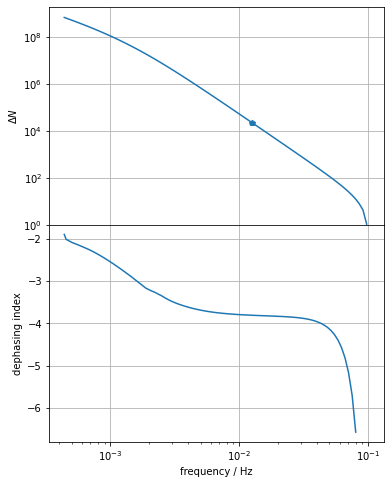

In [17]:
# Alternatively, use the plot_utils function (and additionally plot the dephasing index)
fig, axes = plt.subplots(2, 1, figsize=(6,8), sharex='all')
imripy.plot_utils.plotDeltaN(hs, ev_0, ev, axes[0], ax_di=axes[1], plotFgw5year=True);
fig.subplots_adjust(hspace=0); axes[0].grid(); axes[1].grid()
axes[0].set_ylim(bottom=1.)
axes[1].set_xscale('log'); axes[1].set_xlabel("frequency / Hz"); axes[1].set_ylabel("dephasing index"); axes[0].set_ylabel("$\Delta N$")

### Do the same for an eccentric inspiral

In [18]:
a0 = 100. * hs.r_isco
e0 = 0.5    

ko_initial = kepler.KeplerOrbit(hs, m2, a0, e0)
a_fin = hs.r_isco

ev_ecc = imripy.inspiral.Classic.Evolve(hs, ko_initial)

Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.5  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-10
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1.2885s real time


Text(0, 0.5, 'radius / $r_{isco}$')

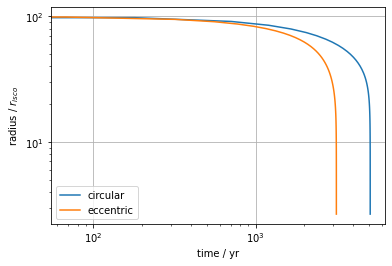

In [19]:
# Plot the result and compare to circular case
plt.loglog(ev.t/c.year_to_pc,  ev.R/hs.r_isco, label='circular')
plt.loglog(ev_ecc.t/c.year_to_pc,  ev_ecc.a/hs.r_isco, label='eccentric')
plt.grid(); plt.legend(); plt.xlabel("time / yr"); plt.ylabel("radius / $r_{isco}$")

Text(0, 0.5, 'eccentricity')

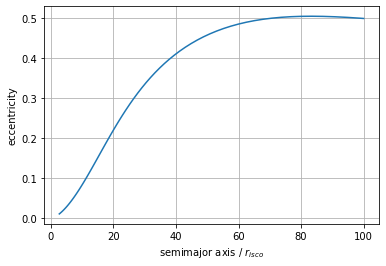

In [20]:
# Plot eccentricity vs semimajor axis
plt.plot(ev_ecc.a/hs.r_isco,  ev_ecc.e)
plt.grid(); plt.xlabel("semimajor axis / $r_{isco}$"); plt.ylabel("eccentricity")

Text(0, 0.5, 'semimajor axis / $r_{isco}$')

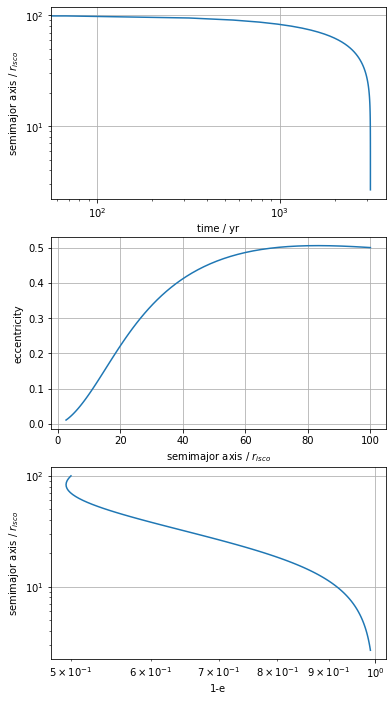

In [21]:
# Alternatively use the plot_utils
fig, axes = plt.subplots(3,1, figsize=(6, 12))
imripy.plot_utils.plotEvolution(hs, ev_ecc, ax_a=axes[0], ax_ae=axes[1], ax_1mea=axes[2])
axes[0].grid(); axes[0].set_xlabel("time / yr"); axes[0].set_ylabel("semimajor axis / $r_{isco}$")
axes[1].grid(); axes[1].set_xlabel("semimajor axis / $r_{isco}$"); axes[1].set_ylabel("eccentricity");
axes[2].grid(); axes[2].set_xscale('log'); axes[2].set_xlabel("1-e"); axes[2].set_ylabel("semimajor axis / $r_{isco}$")

Text(0.5, 0, 'time / s')

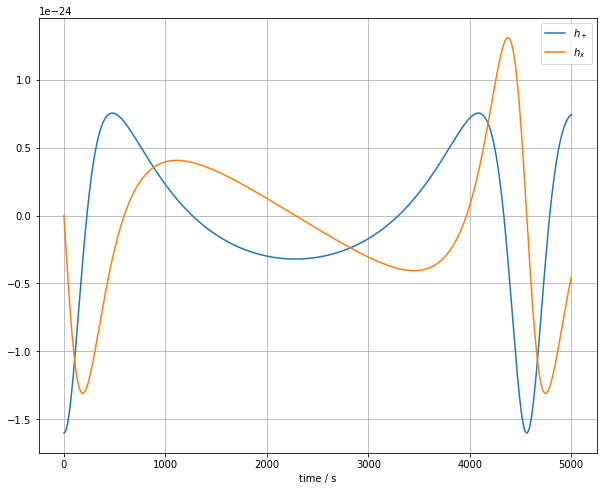

In [22]:
t_grid = np.linspace(0., 5000.*c.s_to_pc, 500)   # Look at the first 5000s of inspiral to see the eccentric effects
h_plus, h_cross = imripy.waveform.h(hs, ev_ecc, t_grid)

plt.figure(figsize=(10,8))
plt.plot(t_grid/c.s_to_pc, h_plus, label="$h_+$")
plt.plot(t_grid/c.s_to_pc, h_cross, label="$h_x$")
plt.grid(); plt.legend(); plt.xlabel("time / s")

(1e-24, 3.960972622757756e-16)

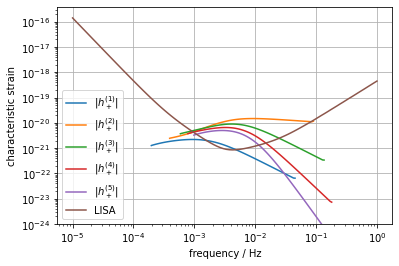

In [23]:
# Plot the first five harmonics
n_comp = 5

wfs = [imripy.waveform.h_n(n, hs, ev_ecc, acc=1e-13) for n in range(1, n_comp+1)]

for i in range( len(wfs)):
    plt.loglog(wfs[i][0]/c.hz_to_invpc, 2.*wfs[i][0]*np.abs(wfs[i][1]), label=r"$|h^{(" + str(i+1) + ")}_+|$")

Lisa = imripy.detector.Lisa()
f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
plt.loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA')
plt.grid(); plt.legend(); plt.xlabel("frequency / Hz"); plt.ylabel("characteristic strain"); plt.ylim(bottom=1e-24)

(1e-24, 3.960972622757756e-16)

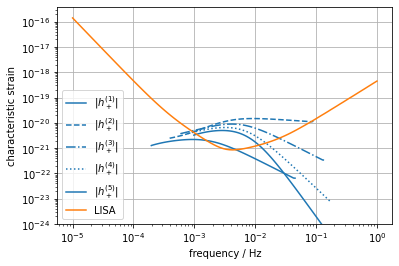

In [24]:
imripy.plot_utils.plotGWcharacteristicStrain(hs, ev_ecc, plt.gca(), harmonics=[1,2,3,4,5], label="$|h^{{({0})}}_+|$") 
# for use with string.format put {0} for the harmonic and {{ }} for escaping { }

Lisa = imripy.detector.Lisa()
f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
plt.loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA')
plt.legend(); plt.grid(); plt.xlabel("frequency / Hz"); plt.ylabel("characteristic strain"); plt.ylim(bottom=1e-24)